<a href="https://colab.research.google.com/github/subhascodes/Responsible_AI_Class/blob/main/Responsible_AI_(Graph_Models_and_Similarity).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

df = pd.read_csv('/content/movielens_sample_dataset_1500.csv')  # Update with your filename
print(df.head())
print(df.columns)


   userId  movieId  rating   timestamp                               title  \
0      18        1     3.0  1108273483                    Toy Story (1995)   
1      18        3     1.5  1108273290             Grumpier Old Men (1995)   
2      18        5     4.0  1108273945  Father of the Bride Part II (1995)   
3      18        7     4.0  1108273895                      Sabrina (1995)   
4      18       10     4.0  1108273566                    GoldenEye (1995)   

                                        genres  year  
0  Adventure|Animation|Children|Comedy|Fantasy  1995  
1                               Comedy|Romance  1995  
2                                       Comedy  1995  
3                               Comedy|Romance  1995  
4                    Action|Adventure|Thriller  1995  
Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres', 'year'], dtype='object')


In [11]:
import pandas as pd
import networkx as nx

# Load dataset
df = pd.read_csv('/content/movielens_sample_dataset_1500.csv')  # Corrected filename

G = nx.Graph()

# Add Movie nodes with attributes
for idx, row in df.iloc[:300].iterrows():
    movie_node = f"Movie_{row['movieId']}"
    # Add movie node with title, year
    if not G.has_node(movie_node):
        G.add_node(movie_node, type='movie', title=row['title'], year=row['year'])

    # Add Genre nodes and edges
    if pd.notna(row['genres']):
        genres = row['genres'].split('|')
        for genre in genres:
            if not G.has_node(genre):
                G.add_node(genre, type='genre')
            # Add edge between movie and genre
            if not G.has_edge(movie_node, genre):
                G.add_edge(movie_node, genre, relation='has_genre')

# (Optional) Add edges between movies sharing genres to model similarity explicitly
movies = [n for n, attr in G.nodes(data=True) if attr.get('type') == 'movie']
for i in range(len(movies)):
    for j in range(i+1, len(movies)):
        movie1 = movies[i]
        movie2 = movies[j]
        genres1 = {nbr for nbr in G.neighbors(movie1) if G.nodes[nbr]['type'] == 'genre'}
        genres2 = {nbr for nbr in G.neighbors(movie2) if G.nodes[nbr]['type'] == 'genre'}
        # If they share at least one genre, create similarity edge
        if genres1 & genres2:
            G.add_edge(movie1, movie2, relation='similar_genre')

# Now graph G has movies connected to genres and movies connected to similar movies by genre

In [12]:
def graph_to_mermaid(G, max_movies=20):
    mermaid_str = "graph TD\n"
    added_nodes = set()
    movie_count = 0

    # Add movie nodes (limit for readability)
    for node, attrs in G.nodes(data=True):
        if attrs.get('type') == 'movie':
            label = f"{attrs['title']} ({attrs['year']})"
            mermaid_str += f'    {node}["{label}"]\n'
            added_nodes.add(node)
            movie_count += 1
            if movie_count >= max_movies:
                break

    # Add edges between movie and genre, and between similar movies, only if both nodes were added above
    for u, v, data in G.edges(data=True):
        if u in added_nodes and v in added_nodes:
            relation = data.get('relation', '')
            if relation == 'has_genre':
                mermaid_str += f'    {u} -->|has genre| {v}\n'
            elif relation == 'similar_genre':
                mermaid_str += f'    {u} ---|similar genre| {v}\n'
        elif u in added_nodes and G.nodes[v].get('type') == 'genre':
            # Show movie to genre edge if genre is not a movie type and movie node is in subset
            relation = data.get('relation', '')
            if relation == 'has_genre':
                mermaid_str += f'    {u} -->|has genre| {v}\n'

    return mermaid_str

mermaid_code = graph_to_mermaid(G)
print(mermaid_code)


graph TD
    Movie_1["Toy Story (1995) (1995)"]
    Movie_3["Grumpier Old Men (1995) (1995)"]
    Movie_5["Father of the Bride Part II (1995) (1995)"]
    Movie_7["Sabrina (1995) (1995)"]
    Movie_10["GoldenEye (1995) (1995)"]
    Movie_11["American President, The (1995) (1995)"]
    Movie_17["Sense and Sensibility (1995) (1995)"]
    Movie_19["Ace Ventura: When Nature Calls (1995) (1995)"]
    Movie_47["Seven (a.k.a. Se7en) (1995) (1995)"]
    Movie_50["Usual Suspects, The (1995) (1995)"]
    Movie_95["Broken Arrow (1996) (1996)"]
    Movie_110["Braveheart (1995) (1995)"]
    Movie_141["Birdcage, The (1996) (1996)"]
    Movie_153["Batman Forever (1995) (1995)"]
    Movie_160["Congo (1995) (1995)"]
    Movie_165["Die Hard: With a Vengeance (1995) (1995)"]
    Movie_173["Judge Dredd (1995) (1995)"]
    Movie_186["Nine Months (1995) (1995)"]
    Movie_253["Interview with the Vampire: The Vampire Chronicles (1994) (1994)"]
    Movie_260["Star Wars: Episode IV - A New Hope (1977) (1977)"]

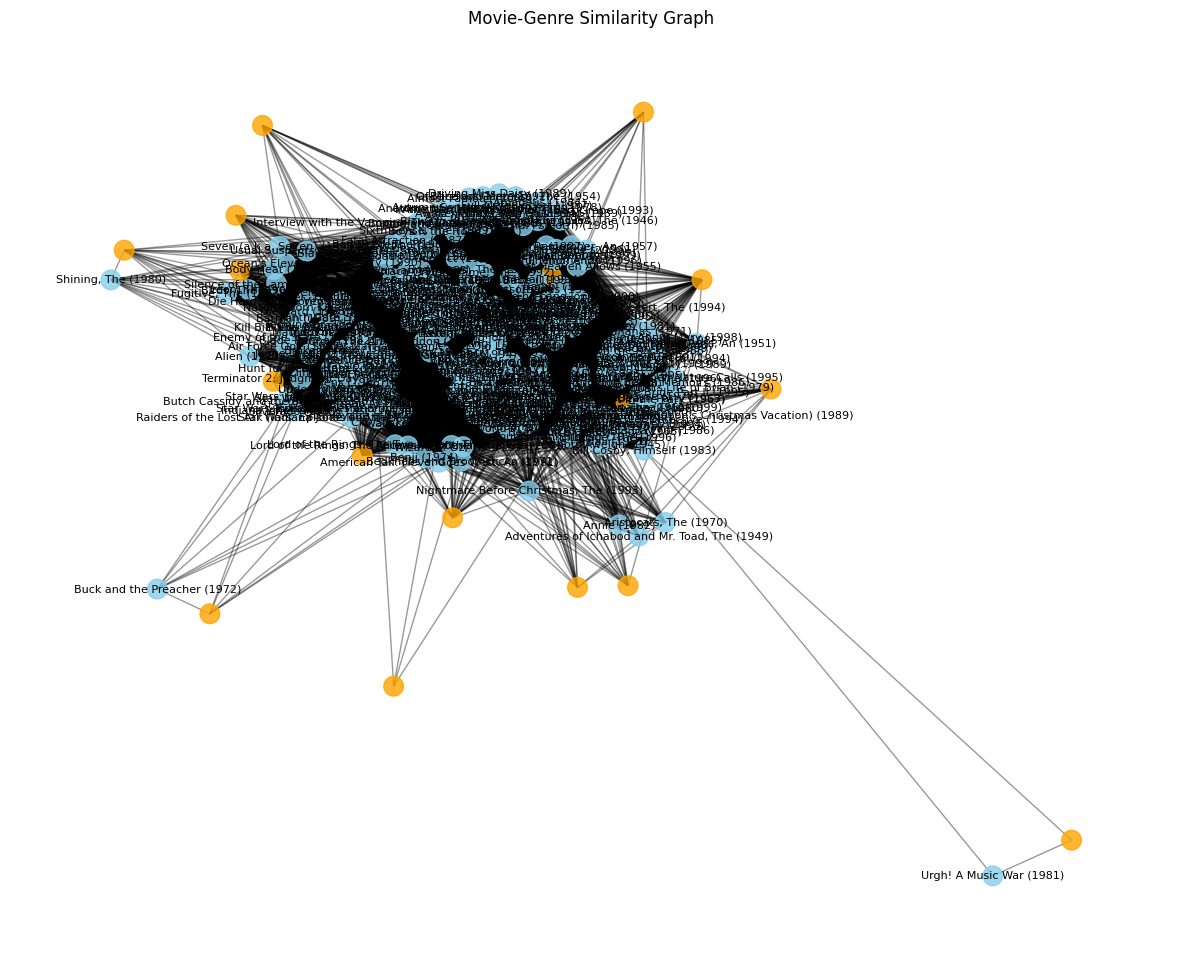

In [13]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
# Draw graph with colored nodes by type for clarity
plt.figure(figsize=(15, 12))
pos = nx.spring_layout(G, k=0.15, seed=42)  # positions for all nodes

# Node coloring: movies = skyblue, genres = orange
node_colors = []
for node in G.nodes():
    if G.nodes[node]['type'] == 'movie':
        node_colors.append('skyblue')
    else:
        node_colors.append('orange')

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=200, alpha=0.8)

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.4)

# Draw labels only for movie nodes (to reduce clutter)
movie_labels = {node: G.nodes[node]['title'] for node in G.nodes() if G.nodes[node]['type'] == 'movie'}
nx.draw_networkx_labels(G, pos, labels=movie_labels, font_size=8)

plt.title("Movie-Genre Similarity Graph")
plt.axis('off')
plt.show()
